# Prepare Data

In [1]:
import matplotlib.pyplot as plt
import astropy.units as u
import pandas as pd
import numpy as np
import os
from IPython.display import display
%matplotlib widget

def show_active():
    fig = plt.gcf()
    display(fig)
    plt.close(fig)

folder_path_win = os.path.dirname('C:/Users/mikel/Desktop/grid_output/')
folder_path_wsl = os.path.dirname('/mnt/c/Users/mikel/Desktop/grid_output/')
folder_path = folder_path_win
runs_path = os.path.join(folder_path, '2020jfo.log')
param_names = ['log_lsun', 't_exp', 't_inner', 'v_start']
limits = [(8, 10.5), (11, 15), (11800, 15800), (5800, 6600)]

# Read data
runs_df = pd.read_json(runs_path, lines=True)
wav = None
seds = []
for run in runs_df.itertuples():
    sed_df = pd.read_csv(os.path.join(folder_path, run.id + '_sed.csv'))
    seds.append(sed_df['L_density'].values)
    if wav is None:
        wav = sed_df['wavelength'].values

# Prepare for interpolation
def convert(v):
    return u.Quantity(v).value
X = runs_df.drop('id', axis=1).reset_index(drop=True).map(convert)
y = np.array(seds)

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

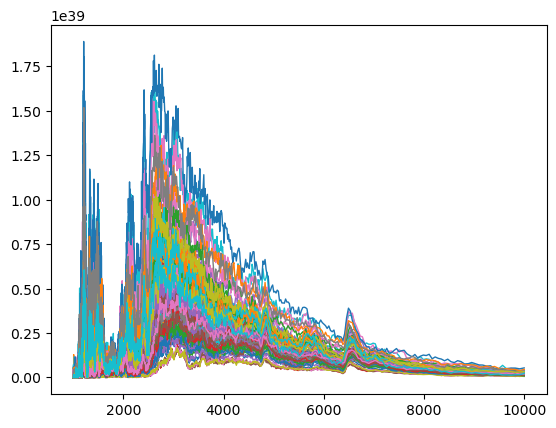

In [2]:
# View data
plt.figure()
for y_i in y[:100]:
    plt.plot(wav, y_i, lw=1)
show_active()

# Fit Models

In [3]:
# Linear interpolator
from scipy.interpolate import LinearNDInterpolator
interp = LinearNDInterpolator(X_train, y_train)

In [4]:
# Find hyperparameters
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

if False:
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPRegressor(
            max_iter=10000, activation='relu', alpha=1e-3, learning_rate_init=1e-2, random_state=0, early_stopping=False,
        ))
    ])

    s = 450 # 2/3 of data, training size
    param_grid = {
        'mlp__hidden_layer_sizes': [(200, 100, 50, 25, 12), (200, 100, 50, 25)],
        #'mlp__activation': ['relu', 'tanh'],
        #'mlp__alpha': [1e-5, 1e-4, 1e-3],
        #'mlp__learning_rate_init': [1e-3, 1e-2]
    }

    search = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    search.fit(X, y)
    best_model = search.best_estimator_

    results = pd.DataFrame(search.cv_results_).sort_values('rank_test_score')
    print(results[['param_mlp__hidden_layer_sizes', 'std_test_score']])

    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print("Test MSE:", mse)
    print(search.best_params_)


In [5]:
# MLPRegressor
# from sklearn.neural_network import MLPRegressor
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline

# mlp = MLPRegressor(
#     max_iter=10000, activation='relu', alpha=1e-3, learning_rate_init=1e-2, hidden_layer_sizes=(200, 100), early_stopping=False
# )
# model = Pipeline([
#     ('scaler', StandardScaler()),
#     ('mlp', mlp)
# ])
# model.fit(X_train, y_train)
#print(mlp.best_validation_score_)

# y_pred = model.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# print("Test MSE:", mse)

C:\Users\mikel\AppData\Local\Temp\ipykernel_22564\830547478.py:5: RuntimeWarning: Mean of empty slice
  mfe = np.nanmean(fe, axis=1)


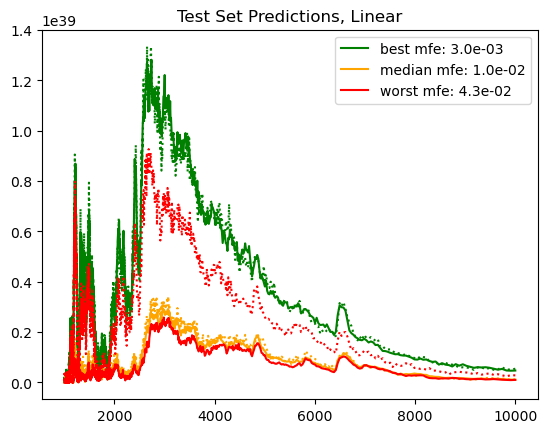

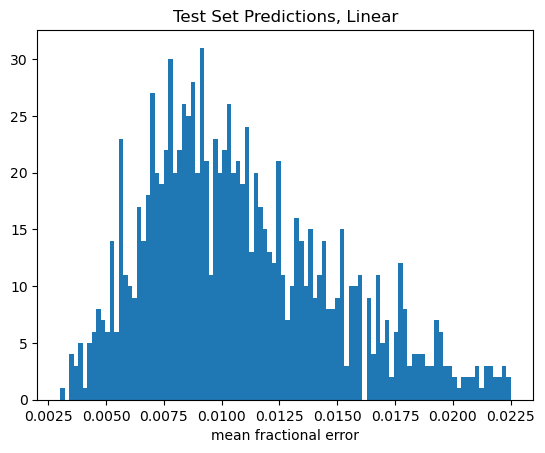

mean mfe: 1.2e-02


In [41]:
def evaluate_predictions(y_test, y_pred, x_axis, title):
    with np.errstate(all='ignore'):
        fe = np.abs(np.log10(y_pred + 1) - np.log10(y_test + 1)) / np.log10(y_test + 1)
        fe[np.isinf(fe)] = np.nan
        mfe = np.nanmean(fe, axis=1)

    # Filter out predictions that have an invalid mfe
    mask = np.isfinite(mfe)
    fe = fe[mask]
    mfe = mfe[mask]
    tests = y_test[mask]
    preds = y_pred[mask]

    # Sort by mfe
    total = len(mfe)
    sorted_indices = np.argsort(mfe)
    min_i = sorted_indices[0]
    med_i = sorted_indices[total // 2]
    max_i = sorted_indices[total - 1]

    # Plot best, median, and worst predictions
    plt.figure()
    for index, color, type in [(min_i, 'green', 'best'), (med_i, 'orange', 'median'), (max_i, 'red', 'worst')]:
        plt.plot(x_axis, preds[index], c=color, label=type + ' mfe: ' + f'{mfe[index]:.1e}')
        plt.plot(x_axis, tests[index], c=color, ls=':')
    plt.title(title)
    plt.legend()
    show_active()

    # Histogram
    mask = mfe <= np.percentile(mfe, 95)
    plt.figure()
    plt.hist(mfe[mask], 100)
    plt.title(title)
    plt.xlabel('mean fractional error')
    show_active()

    print('mean mfe: ' + f'{np.mean(mfe):.1e}')

evaluate_predictions(y_test, interp(X_test), wav, 'Test Set Predictions, Linear')
#evaluate_predictions(y_test, model.predict(X_test), wav, 'Test Set Predictions, MLPRegressor')

# Visualize Parameters

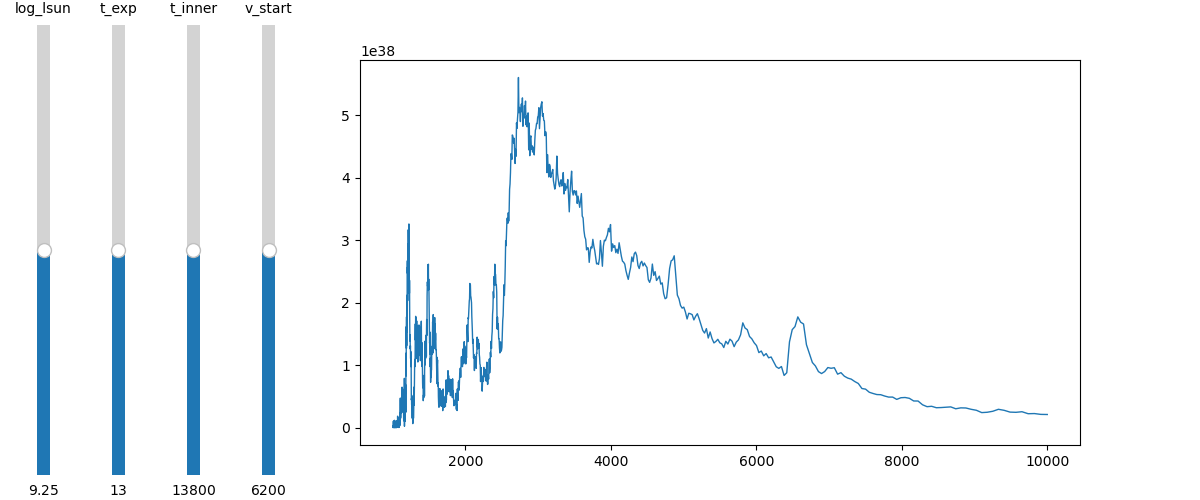

In [36]:
from matplotlib.widgets import Slider

active_vals = np.mean(limits, axis=1)

def recalc_y():
    X_mod = pd.DataFrame([active_vals], columns=param_names)
    #y_mod = model.predict(X_mod)[0]
    y_mod = interp(list(X_mod.values))[0]
    return y_mod

fig, ax = plt.subplots(figsize=(12, 5))
fig.subplots_adjust(left=0.3)
line, = ax.plot(wav, recalc_y(), lw=1)
fig.canvas.toolbar_position = 'bottom'
sliders = []

for index, name in enumerate(param_names):
    ax_slider = fig.add_axes([0.025 + 0.25 * index / 4, 0.05, 0.0225, 0.9])
    slider = Slider(
        ax=ax_slider,
        label=param_names[index],
        valmin=limits[index][0],
        valmax=limits[index][1],
        valinit=active_vals[index],
        orientation='vertical'
    )

    def make_update(index):
        def update(val):
            active_vals[index] = val
            line.set_ydata(recalc_y())
            ax.relim()
            ax.autoscale_view()
            fig.canvas.draw_idle()
        return update
    slider.on_changed(make_update(index))
    sliders.append(slider)

plt.show()

# Fit Observed

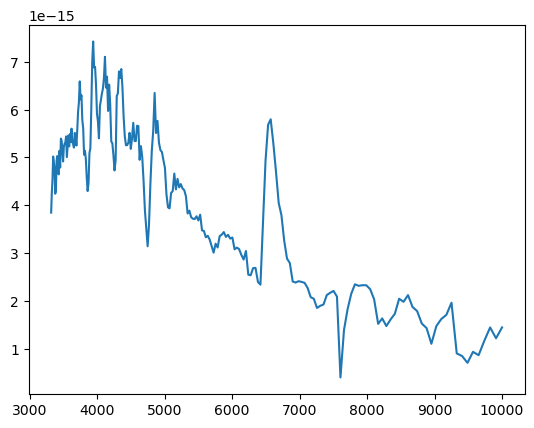

c:\Users\mikel\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [8]:
# Get observed data
from scipy.interpolate import interp1d
obs_df = pd.read_csv('2020jfo-FLOYDS-S-2020-05-19.csv', comment='#')
y_obs = interp1d(obs_df['wavelength'], obs_df['flux'], bounds_error=False)(wav)

# Flux calibrate
from astropy.constants import c
filter_df = pd.read_csv('Palomar_ZTF.r_fil.dat', names=['wavelength', 'transmission'], sep=' ')
transmission = interp1d(filter_df['wavelength'], filter_df['transmission'], bounds_error=False)(wav)
m_AB = 14.547
f_0 = 2.64009e-9 * u.erg/u.cm**2/u.s/u.AA
f_density = 10**(m_AB/-2.5) * f_0
mask = np.isfinite(transmission)
y_obs *= np.sum(f_density.value*transmission[mask]) / np.sum(y_obs[mask])

plt.figure()
plt.plot(wav, y_obs)
show_active()

# Add scale as optimization parameter
opt_start = list(X_train.mean().values)
opt_limits = limits.copy()
opt_start.append(10**53)
opt_limits.append((10**50, 10**60))

# Find best fit
results = []

def f(x):
    scale = x[-1]
    X_mod = pd.DataFrame([x[:-1]], columns=param_names)
    #y_mod = model.predict(X_mod)[0]
    y_mod = interp(list(X_mod.values))[0]
    mask = ~(np.isnan(y_mod) | np.isnan(y_obs))
    if not np.any(mask):
        return np.inf
    else:
        y1 = y_mod[mask]
        y2 = y_obs[mask]*scale
        fe = np.abs(y1 - y2)/y2
        mean_fe = np.mean(fe)
        max_fe = np.max(fe)
        results.append({'mean_fe': mean_fe, 'max_fe': max_fe, 'X': X_mod, 'y': y_mod, 'scale': scale})
        return mean_fe

from scipy.optimize import differential_evolution
result = differential_evolution(f, x0=opt_start, bounds=opt_limits)
results = sorted(results, key=lambda x: x['mean_fe'])


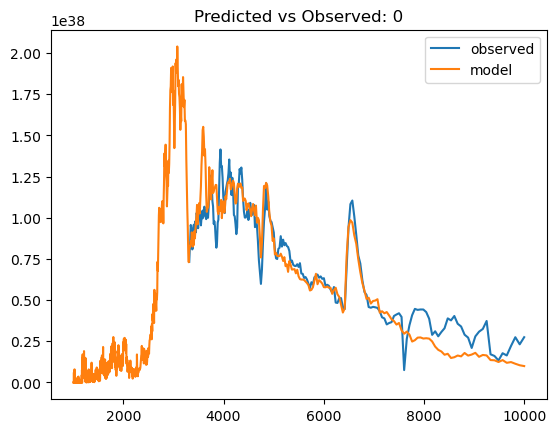

mean fe: 0.15545849801914757
max fe: 2.9303642740802243
scale: 1.9054283368345173e+52
distance: 12.619461777707462 Mpc
X:     log_lsun      t_exp      t_inner      v_start
0  10.006166  13.356523  11888.77105  5879.888876


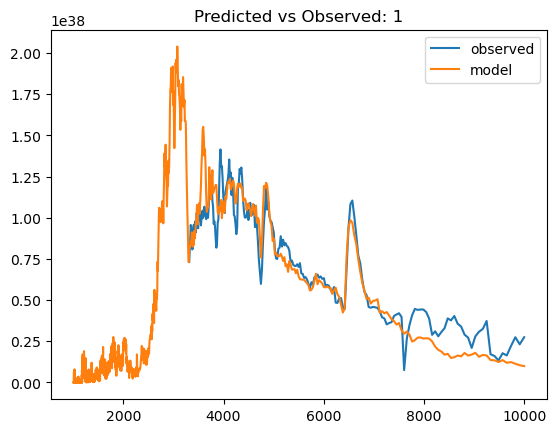

mean fe: 0.15545849801914757
max fe: 2.9303642740802243
scale: 1.9054283368345173e+52
distance: 12.619461777707462 Mpc
X:     log_lsun      t_exp      t_inner      v_start
0  10.006166  13.356523  11888.77105  5879.888876


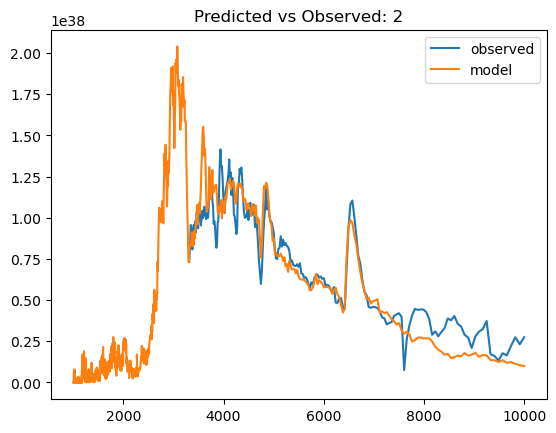

mean fe: 0.15545849813805213
max fe: 2.9303643357669764
scale: 1.905428308441423e+52
distance: 12.619461683685149 Mpc
X:     log_lsun      t_exp      t_inner      v_start
0  10.006166  13.356523  11888.77105  5879.888876


In [9]:
for i in range(3):
    mean_fe = results[i]['mean_fe']
    max_fe = results[i]['max_fe']
    X_mod = results[i]['X']
    y_mod = results[i]['y']
    scale = results[i]['scale']

    mask = ~np.isnan(y_obs)
    plt.figure()
    plt.plot(wav, y_obs * scale, label='observed')
    plt.plot(wav, y_mod, label='model')
    plt.title('Predicted vs Observed: ' + str(i))
    plt.legend()
    show_active()
    # spectra MJD = 58988
    # VARLIST:  MJD        FLT  FLUXCAL   FLUXCALERR    MAG     MAGERR     MAGSYS   TELESCOPE    INSTRUMENT   DQ
    # OBS:      58986.256  r-ZTF  151722.942  4208.276  14.547  0.030  None  P48  ZTF-Cam  None
    # flux in erg/s/ang/cm^2, lum in erg/s/ang, F = (1/k)L, k = 4*pi*d^2
    distance = np.sqrt(scale/4/np.pi) * u.cm

    print('mean fe:', mean_fe)
    print('max fe:', max_fe)
    print('scale:', scale)
    print('distance:', distance.to(u.Mpc))
    print('X:', X_mod)